In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import hist

import sys
sys.path.append("../..")
from analyzer.dumperReader.reader import *

In [2]:
reader = DumperReader("/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v2/dumper_101.root") #"../runs_results/histo.root:ticlDumper")
ale_tree = uproot.open("/grid_mnt/data_cms_upgrade/tarabini/electrons_pre4_PU/step3_noLinking/step3_101.root:ana/hgc")

In [3]:
reader.tracksters_zipped

<Array [[{ts_id: 0, time: -99, ...}, ...], ...] type='100 * var * trackster...'>

In [4]:
_ar = ale_tree.arrays(filter_name="multiclus*")
ts_ale = ak.zip({"ts_id" : ak.local_index(_ar.multiclus_energy, axis=1)} | 
                      {key : _ar[key] for key in _ar.fields 
                        if key not in ["multiclus_lastLay"] # multiclus_lastLay is not filled for some reason
                        },
            depth_limit=2, # don't try to zip vertices
            #with_name="tracksters"
        )
ts_ale

<Array [[{ts_id: 0, ...}, ..., {...}], ...] type='100 * var * {ts_id: int64...'>

In [5]:
ts_ale_sorted = ts_ale[ak.argsort(ts_ale.multiclus_pt, ascending=False)]
ts_ale_sorted

<Array [[{ts_id: 1965, ...}, ..., {...}], ...] type='100 * var * {ts_id: in...'>

In [6]:
ts_theo_sorted = reader.tracksters_zipped[ak.argsort(reader.tracksters_zipped.raw_pt, ascending=False)]
ts_theo_sorted

<Array [[{ts_id: 1965, ...}, ..., {...}], ...] type='100 * var * tracksters...'>

In [7]:
ts_ale_sorted.multiclus_energy

<Array [[256, 252, 64.9, ..., 0.625, 0.723], ...] type='100 * var * float32'>

In [8]:
ts_theo_sorted.raw_energy

<Array [[256, 252, 64.9, ..., 2.01, 1.13], ...] type='100 * var * float32'>

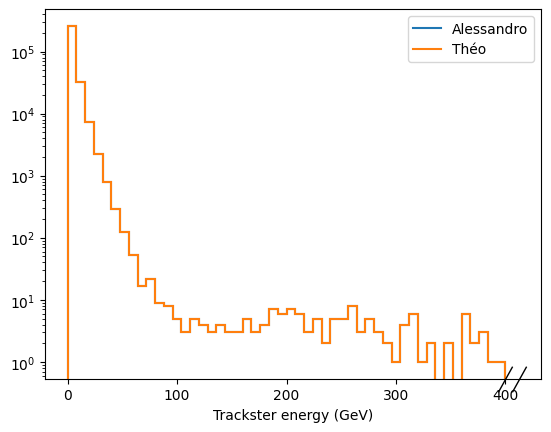

In [9]:
h_tsENergy = hist.Hist(hist.axis.Regular(50, 0, 400, label="Trackster energy (GeV)"))
hep.histplot([h_tsENergy.copy().fill(ak.flatten(ts_ale_sorted.multiclus_energy)), h_tsENergy.copy().fill(ak.flatten(ts_theo_sorted.raw_energy))],
             label=["Alessandro", "Théo"], yerr=False)
plt.yscale("log")
plt.legend()

In [11]:
ale_gun_ = ale_tree.arrays(filter_name="gunparticle*")
ale_gun = ak.zip({key : ale_gun_[key][:, 0] for key in ale_gun_.fields})
ale_gun

<Array [[{gunparticle_id: 11, ...}, ...], ...] type='100 * var * {gunpartic...'>

In [12]:
ale_gun_[0]

<Record {gunparticle_id: [[...]], ...} type='{gunparticle_id: var * var * i...'>

In [13]:
ale_gun.gunparticle_energy

<Array [[261, 261], [233, ...], ..., [235, 235]] type='100 * var * float32'>

In [14]:
reader.simTrackstersCP.regressed_energy

<Array [[261, 261], [233, ...], ..., [235, 235]] type='100 * var * float32'>

In [15]:
ale_gun.gunparticle_energy

<Array [[261, 261], [233, ...], ..., [235, 235]] type='100 * var * float32'>

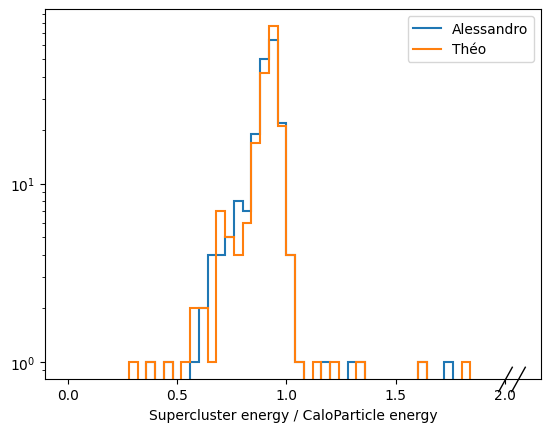

In [16]:
eratio_axis = partial(hist.axis.Regular, 50, 0, 2, name="e_ratio")
h_scOverCP_energy = hist.Hist(eratio_axis(label="Supercluster energy / CaloParticle energy"))
hep.histplot([h_scOverCP_energy.copy().fill(ak.flatten(ts_ale_sorted.multiclus_energy[:, :2]/ale_gun.gunparticle_energy)), 
              h_scOverCP_energy.copy().fill(ak.flatten(ts_theo_sorted.raw_energy[:, :2]/reader.simTrackstersCP.raw_energy))],
             label=["Alessandro", "Théo"], yerr=False)
plt.yscale("log")
plt.legend()